In [6]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [15]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import load_iris
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import numpy as np
from sklearn import linear_model
import scipy.io as spio
from sklearn.multioutput import MultiOutputRegressor
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
import shelve
import pandas as pd
import pickle
from sklearn.metrics import *

In [2]:
lattice = 'cubic'
column_names = ['avg atomic mass','vol per atom','std Li neighbor count','std Li bond ionicity','Li bond ionicity','Li neighbor count','Li-Li bonds per Li','avg Li bond length','sublattice bond ionicity','sublattice neighbor count','anion framework coordination','min anion-anion sep dist','vol per anion','min Li-anion sep dist','Li number conc','mass density','min Li-Li sep dist','sublattice electronegativity','RBI','RNB']
coeff=0
data = spio.loadmat(lattice+'-data-posd-features.mat')
xdatadf = pd.DataFrame(data['xdata'], columns = column_names)
#column_names_old = ['avg atomic mass','vol per atom','std Li neighbor count','std Li bond ionicity','Li bond ionicity','Li neighbor count','Li-Li bonds per Li','avg Li bond length','sublattice bond ionicity','sublattice neighbor count','anion framework coordination','min anion-anion sep dist','vol per anion','min Li-anion sep dist','Li number conc','mass density','min Li-Li sep dist','sublattice electronegativity','RBI','RNB']
column_names_for_ml = ['vol per atom','std Li neighbor count','std Li bond ionicity','Li bond ionicity','Li neighbor count','Li-Li bonds per Li','sublattice bond ionicity','sublattice neighbor count','anion framework coordination','min anion-anion sep dist','vol per anion','min Li-anion sep dist','mass density','min Li-Li sep dist','sublattice electronegativity','RBI','RNB']
X = xdatadf[column_names_for_ml].values
#X = np.hstack((xdatadf.values[:,:16],xdatadf.values[:,18:]))
y = data['ydata'][:,coeff]
X.shape

(170, 17)

In [188]:
print(X[2,:])
data['mps']

[14.727705  0.        0.630593  1.04     18.        6.        0.288889
 18.        8.        2.751377 19.63694   2.751377 16.691922  3.891034
  2.28      3.6       1.      ]


array(['mp-976334', 'mp-861936', 'mp-861931', 'mp-867226', 'mp-30765 ',
       'mp-23259 ', 'mp-11248 ', 'mp-1646  ', 'mp-23222 ', 'mp-976023',
       'mp-976256', 'mp-22905 ', 'mp-934   ', 'mp-1138  ', 'mp-11489 ',
       'mp-1934  ', 'mp-1437  ', 'mp-2012  ', 'mp-30764 ', 'mp-567395',
       'mp-569849', 'mp-11644 ', 'mp-10890 ', 'mp-23703 ', 'mp-2743  ',
       'mp-22899 ', 'mp-2286  ', 'mp-1153  ', 'mp-755309', 'mp-865868',
       'mp-865866', 'mp-861629', 'mp-862297', 'mp-867196', 'mp-16349 ',
       'mp-865912', 'mp-867927', 'mp-865793', 'mp-867834', 'mp-865444',
       'mp-867253', 'mp-542435', 'mp-3201  ', 'mp-865231', 'mp-10180 ',
       'mp-31168 ', 'mp-5920  ', 'mp-862657', 'mp-864598', 'mp-861616',
       'mp-862316', 'mp-16271 ', 'mp-12558 ', 'mp-864631', 'mp-7575  ',
       'mp-3887  ', 'mp-13944 ', 'mp-21026 ', 'mp-11947 ', 'mp-11512 ',
       'mp-862321', 'mp-861896', 'mp-864930', 'mp-21029 ', 'mp-12411 ',
       'mp-861666', 'mp-865872', 'mp-861901', 'mp-865582', 'mp-8

In [189]:
X

array([[14.929776,  0.      ,  0.444402, ...,  1.9     ,  0.5     ,
         1.      ],
       [14.847659,  0.      ,  0.591787, ...,  2.2     ,  3.6     ,
         1.      ],
       [14.727705,  0.      ,  0.630593, ...,  2.28    ,  3.6     ,
         1.      ],
       ...,
       [29.043597,  0.      ,  0.      , ...,  2.423333,  1.662119,
         0.473684],
       [29.899182,  0.      ,  0.      , ...,  2.417778,  1.655476,
         0.473684],
       [34.124211,  0.      ,  0.      , ...,  2.346667,  1.733641,
         0.473684]])

In [12]:
models_and_parameters = {
  'lasso': (linear_model.Lasso(),
              {'reg__alpha': [0.01, 0.1, 0.5, 1.,5.,10.]}),
    'elnet': (linear_model.ElasticNet(),
              {'reg__alpha':[0.01, 0.1, 0.5, 1, 5., 10.], 'reg__l1_ratio':[0.,0.1,0.5,1.,2.1]}),
    'krg': (KernelRidge(),
            {'reg__kernel':['rbf','linear'], 'reg__alpha': [1e0, 0.1, 1e-2, 1e-3], 'reg__gamma': np.logspace(-2, 2, 5)}),
    'gpr': (GaussianProcessRegressor(kernel = kernels.RBF()),
            {'reg__kernel__length_scale':[0.01, 0.1, 1., 2., 10., 100.], 'reg__kernel__length_scale_bounds':[(1e-2,1.),(1e-1,1.),(1e-1,10.),(1.,10.),(1.,100.)\
,(1e-2,1e2)]}),
    'gbr': (GradientBoostingRegressor(learning_rate=0.01, min_samples_split=2, max_features='sqrt', loss='ls', subsample=0.4),
            {'reg__max_depth': [2,3,4,10,20,50],'reg__min_samples_leaf': [2,3,4,10], 'reg__learning_rate':[0.01, 0.1], 'reg__max_features':['auto', 'sqrt', 'l\
og2']}),
    'ada': (AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),n_estimators=500,learning_rate=0.01),#max_depth alone doesn't work probably               
            {'reg__base_estimator__max_depth': [2,3,4,10], 'reg__base_estimator':[DecisionTreeRegressor(max_depth = 4, max_features='auto'),
                                                                                    DecisionTreeRegressor(max_depth = None, max_features='auto'),
                                                                                    DecisionTreeRegressor(max_depth = 4, max_features='sqrt'),
                                                                                     DecisionTreeRegressor(max_depth = None, max_features='sqrt')]}),
    'svr': (SVR(),
            {'reg__C': [0.01, 0.05, 0.1, 1], 'reg__kernel': ['linear', 'rbf']}),
    'rf': (RandomForestRegressor(),
           {'reg__max_depth': [None, 5, 10, 50]}),
    'brg': (linear_model.BayesianRidge(fit_intercept=True),
            {'reg__alpha_1': [1.e-6, 1.e-5]}),
    'lars': (linear_model.Lars(fit_intercept = True, normalize=False),
             {'reg__n_nonzero_coefs': [5, 10, 50, 500, np.inf]}),
    'ard': (linear_model.ARDRegression(),
            {'reg__alpha_1':[1.e-6, 1.e-5]})}

In [191]:
scaler = preprocessing.StandardScaler()
inner_cv = KFold(n_splits=3, shuffle=True)
outer_cv = KFold(n_splits=3, shuffle=True)

In [192]:
model = GradientBoostingRegressor(n_estimators = 500, learning_rate=0.01, min_samples_split=2, max_features='sqrt', loss='ls', subsample=0.4)
params = {'reg__max_depth': [None,2,5,100],'reg__max_features':['auto','sqrt','log2'],'reg__min_samples_split':[2,3,4],'reg__min_samples_leaf':[2,3,4]}
params = {'reg__base_estimator__max_depth': [None,2,4,10,100],
            'reg__base_estimator__max_features':['auto','sqrt','log2',None],
            'reg__base_estimator__min_samples_split':[2,3,4],
            'reg__base_estimator__min_samples_leaf': [1,2,3,4]}
#params = models_and_parameters['gbr'][1]
params = {'reg__max_depth': [2,3,4,10,20,50],
            'reg__min_samples_leaf': [2,3,4,10], 
            'reg__learning_rate':[0.01, 0.1], 
            'reg__max_features':['auto', 'sqrt', 'log2'],
            'reg__min_samples_split':[2,3,4],
             'reg__max_features':[0.3,0.4,0.5,1.0]}
#params = {'reg__base_estimator':[DecisionTreeRegressor(max_depth = 4, max_features='auto'),
#                                DecisionTreeRegressor(max_depth = None, max_features='auto'),
#                                DecisionTreeRegressor(max_depth = 4, max_features='sqrt'),
#                                DecisionTreeRegressor(max_depth = None, max_features='sqrt')]}
pipeline = Pipeline([('transformer', scaler), ('reg', model)])

In [193]:
reg1 = GridSearchCV(estimator=pipeline, param_grid=params, cv=inner_cv, n_jobs=-1)

In [195]:
reg1

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('transformer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reg', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurit...       presort='auto', random_state=None, subsample=0.4, verbose=0,
             warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'reg__max_depth': [2, 3, 4, 10, 20, 50], 'reg__min_samples_leaf': [2, 3, 4, 10], 'reg__learning_rate': [0.01, 0.1], 'reg__max_features': [0.3, 0.4, 0.5, 1.0], 'reg__min_samples_split': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [46]:
#don't run
model=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=100,
                                                            max_features='log2',
                                                            min_samples_leaf= 3,
                                                            min_samples_split= 3))
pipeline = Pipeline([('transformer', scaler), ('reg', model)])
reg1 = Pipeline([('transformer', scaler), ('reg', model)])
#clf.fit(X,y)
#clf.best_params_

In [196]:
#One with GridSearch
reg1.fit(X,y)
print(reg1.best_params_)
#scores=cross_val_score(reg1, X=X, y=y, scoring='neg_mean_squared_error',cv=outer_cv)
r2scores=cross_val_score(reg1, X=X, y=y, scoring='r2',cv=outer_cv)
#rmse_scores = [np.sqrt(abs(s)) for s in scores]
#print(rmse_scores)
print(r2scores)
print('Cross-validation results:')
#print('Folds: %i, mean RMSE: %.3f' % (len(scores), np.mean(np.abs(rmse_scores))))
print('Folds: %i, mean r2: %.3f' % (len(r2scores), np.mean(r2scores)))
#print(sum(y-reg1.predict(X)))
print(y)
print(reg1.predict(X))
#print(y-reg1.predict(X))

[0.49873451 0.58343182 0.72444008]
Cross-validation results:
Folds: 3, mean r2: 0.602
-17.278984687397603
[ 46. 154. 258.  30. 303.  37. 119.  33.  39.  33.  24.  54.  45. 125.
  40.  56.  41.  44. 198.  41.  47.  25. 135.  84.  93.  36.  66.  83.
  30. 192. 147. 131. 222.  70. 140. 112. 356. 131. 149. 131. 131. 216.
  77.  64.  78.  56. 121. 144.  65. 153. 293.  45.  93. 247. 271. 242.
 268.  76.  81. 163. 118.  73. 290.  67.  77. 340. 192.  95.  55. 140.
  78.  99.  39.  32. 188. 109.  72.  93.  83.  51.  62.  88.  40. 109.
  46.  91. 142. 220.  54.  60.  69. 227. 108.  52. 241. 109.  93.  35.
 176.  66.  91. 212. 211.  66.  44. 128. 127. 134.  85. 211.  86.  83.
  81.  91.  55.  47. 130.  74. 130. 159. 101.  55. 295. 243. 152.  69.
 147.  99. 248. 104. 301. 155. 102. 152. 125. 113.  43.  56.  55. 213.
 136. 113.  33. 128. 115. 209.  74. 105. 147. 113. 153.  69.  84. 112.
  99. 259.  49. 302. 193. 103. 125.  62.  63. 213.  32.  33. 112.  27.
  26.  25.]
[ 49.45581813 151.89240649 247

In [153]:
reg1.fit(X,y)
#print(reg1.best_params_)
#scores=cross_val_score(reg1, X=X, y=y, scoring='neg_mean_squared_error',cv=outer_cv)
r2scores=cross_val_score(reg1, X=X, y=y, scoring='r2',cv=outer_cv)
#rmse_scores = [np.sqrt(abs(s)) for s in scores]
#print(rmse_scores)
print(r2scores)
print('Cross-validation results:')
#print('Folds: %i, mean RMSE: %.3f' % (len(scores), np.mean(np.abs(rmse_scores))))
print('Folds: %i, mean r2: %.3f' % (len(r2scores), np.mean(r2scores)))

[0.5816485  0.41169175 0.57618244]
Cross-validation results:
Folds: 3, mean r2: 0.523


In [197]:
print(reg1.best_params_)

{'reg__learning_rate': 0.01, 'reg__max_depth': 4, 'reg__max_features': 0.5, 'reg__min_samples_leaf': 3, 'reg__min_samples_split': 4}


In [18]:
ntdata = spio.loadmat(lattice+'-non-training-data-features.mat')
#Xnt=np.delete(Xnt,18,axis=1)
Xntdatadf = pd.DataFrame(ntdata['xntdata'],columns = column_names)
Xnt = Xntdatadf[column_names_for_ml].values
reg1.predict(Xnt)
#ynt1

array([ 33.8453922 ,  37.07399672,  43.99159744,  73.53437393,
        51.60859113,  51.2793827 ,  64.62747139,  53.65345552,
       117.05036354,  44.07828877,  66.0747928 ,  32.96225783,
        94.92319144,  86.11448027,  69.51150134,  99.10734388,
        90.80815756,  68.76618   , 126.56837803,  36.25356039,
        37.75394035,  39.68775279,  48.5944859 ,  19.16927433,
        39.63464836,  96.53626306,  62.58453553,  42.93247377,
        53.49511249,  47.41717618,  35.88041632,  96.47734928,
        43.22148426, 194.78192007,  28.32795167,  44.86248824,
        59.44192027,  39.67741693,  49.30888089,  63.97654699,
        41.9315336 ,  42.1478234 , 111.05511609,  52.94897337,
       137.28791272,  64.26719787,  45.69298222,  62.30621973,
        66.582139  , 105.40653891,  58.54963764,  63.36398513,
        57.64566935,  39.51113062,  95.92846106,  52.10582273,
       164.47965987,  43.84591047, 134.47747658, 112.75350742,
        78.34006169,  51.31209457, 114.87351082,  73.18

In [207]:
from matminer.figrecipes.plotly.make_plots import PlotlyFig

pf_rf = PlotlyFig(x_title='DFT (MP) C11 (GPa)',
                  y_title='GBR C11 (GPa)',
                  plot_title='GBR',
                  plot_mode='offline',
                  margin_left=150,
                  textsize=35,
                  ticksize=30,
                  filename="gbregression1.html")

# a line to represent a perfect model with 1:1 prediction
xy_line = {'x_col': [0, max(y)],
           'y_col': [0, max(y)],
           'color': 'black',
           'mode': 'lines',
           'legend': None,
           'text': None,
           'size': None}

pf_rf.xy_plot(x_col=y,
              y_col=reg1.predict(X),
              size=3,
              marker_outline_width=0.5,
              #text=df_mp['pretty_formula'],
              add_xy_plot=[xy_line])

In [208]:
s = pickle.dump(reg1,open( "reg1_features.p", "wb" ))

In [114]:
coeff=1
y = data['ydata'][:,coeff]
params=models_and_parameters['krg'][1]
params = {'reg__kernel': ['rbf','linear'], 'reg__alpha': [1e0, 0.1, 1e-2, 1e-3], 'reg__gamma': np.logspace(-4,-2, 2, 5)}
scaler = preprocessing.StandardScaler()
inner_cv = KFold(n_splits=3, shuffle=True)
outer_cv = KFold(n_splits=3, shuffle=True)

In [115]:
model = KernelRidge()
scaler = preprocessing.StandardScaler()
pipeline = Pipeline([('transformer', scaler), ('reg', model)])
reg2 = GridSearchCV(estimator=pipeline, param_grid=params, cv=inner_cv,n_jobs=-1)

In [118]:
reg2.fit(X,y)
print(reg2.best_params_)
scores=cross_val_score(reg2, X=X, y=y, scoring='neg_mean_squared_error',cv=outer_cv)
r2scores=cross_val_score(reg2, X=X, y=y, scoring='r2',cv=outer_cv)
rmse_scores = [np.sqrt(abs(s)) for s in scores]
print('Cross-validation results:')
print('Folds: %i, mean RMSE: %.3f' % (len(scores), np.mean(np.abs(rmse_scores))))
print('Folds: %i, mean r2: %.3f' % (len(r2scores), np.mean(r2scores)))

{'reg__alpha': 0.01, 'reg__gamma': 0.01, 'reg__kernel': 'rbf'}
Cross-validation results:
Folds: 3, mean RMSE: 17.071
Folds: 3, mean r2: 0.821


In [119]:
from matminer.figrecipes.plotly.make_plots import PlotlyFig
pf_rf = PlotlyFig(x_title='DFT (MP) C12 (GPa)',
                  y_title='Kernel Ridge C12 (GPa)',
                  plot_title='Random forest regression',
                  plot_mode='offline',
                  margin_left=150,
                  textsize=35,
                  ticksize=30,
                  filename="fregression2.html")

# a line to represent a perfect model with 1:1 prediction
xy_line = {'x_col': [min(y), max(y)],
           'y_col': [min(y), max(y)],
           'color': 'black',
           'mode': 'lines',
           'legend': None,
           'text': None,
           'size': None}


pf_rf.xy_plot(x_col=y,
              y_col=reg2.predict(X),
              size=3,
              marker_outline_width=0.5,
              #text=df_mp['pretty_formula'],
              add_xy_plot=[xy_line])

ModuleNotFoundError: No module named 'matminer'

In [120]:
import pickle
s = pickle.dump(reg2,open( "reg2_features.p", "wb" ))

In [3]:
coeff=2
y = data['ydata'][:,coeff]
#params=models_and_parameters['brg'][1]
params = {'reg__max_depth': [2,3,4,10,20,50],
            'reg__min_samples_leaf': [2,3,4,10], 
            'reg__learning_rate':[0.01, 0.1], 
            'reg__max_features':['auto', 'sqrt', 'log2'],
            'reg__min_samples_split':[2,3,4],
             'reg__max_features':[0.3,0.4,0.5,1.0]}
scaler = preprocessing.StandardScaler()
inner_cv = KFold(n_splits=3, shuffle=True)
outer_cv = KFold(n_splits=3, shuffle=True)
#model=linear_model.BayesianRidge(normalize=False)
model = GradientBoostingRegressor(n_estimators = 500, learning_rate=0.01, min_samples_split=2, max_features='sqrt', loss='ls', subsample=0.4)
scaler = preprocessing.StandardScaler()
pipeline = Pipeline([('transformer', scaler), ('reg', model)])

In [6]:
reg3 = GridSearchCV(estimator=pipeline, param_grid=params, cv=inner_cv,n_jobs=-1)
reg3
reg3.fit(X,y)
print(reg3.best_params_)
scores=cross_val_score(reg3, X=X, y=y, scoring='neg_mean_squared_error',cv=outer_cv)
r2scores=cross_val_score(reg3, X=X, y=y, scoring='r2',cv=outer_cv)
print(r2scores)
rmse_scores = [np.sqrt(abs(s)) for s in scores]
print('Cross-validation results:')
#print('Folds: %i, mean RMSE: %.3f' % (len(scores), np.mean(np.abs(rmse_scores))))
print('Folds: %i, mean r2: %.3f' % (len(r2scores), np.mean(r2scores)))

{'reg__learning_rate': 0.1, 'reg__max_depth': 3, 'reg__max_features': 0.3, 'reg__min_samples_leaf': 4, 'reg__min_samples_split': 3}
[0.78386083 0.70924085 0.57103718]
Cross-validation results:
Folds: 3, mean r2: 0.688


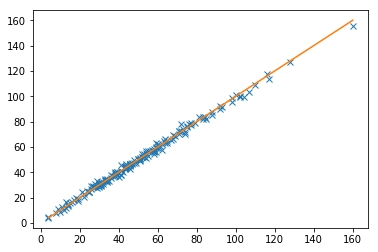

In [8]:
plt.plot(y, reg3.predict(X),'x')
plt.plot(np.linspace(min(y), max(y), 100), np.linspace(min(y), max(y), 100))

In [818]:
from matminer.figrecipes.plotly.make_plots import PlotlyFig
pf_rf = PlotlyFig(x_title='DFT (MP) C44 (GPa)',
                  y_title='Bayesian Ridge C44 (GPa)',
                  plot_title='Random forest regression',
                  plot_mode='offline',
                  margin_left=150,
                  textsize=35,
                  ticksize=30,
                  filename="br3_regression1.html")

# a line to represent a perfect model with 1:1 prediction
xy_line = {'x_col': [min(y), max(y)],
           'y_col': [min(y), max(y)],
           'color': 'black',
           'mode': 'lines',
           'legend': None,
           'text': None,
           'size': None}

pf_rf.xy_plot(x_col=y,
              y_col=reg3.predict(X),
              size=3,
              marker_outline_width=0.5,
              #text=df_mp['pretty_formula'],
              add_xy_plot=[xy_line])

In [9]:
import pickle
s = pickle.dump(reg3,open( "reg3_features.p", "wb" ))

In [16]:
y1t=reg1.predict(X)
y2t=reg2.predict(X)
y3t=reg3.predict(X)
e1t=(y1t+2*y2t)/3
e2t=(y1t-y2t)
e3t=y3t
yall = data['ydata']
print(mean_squared_error(y1t,yall[:,0]))
print(mean_squared_error(y2t,yall[:,1]))
print(mean_squared_error(y3t,yall[:,2]))
print(mean_squared_error(e1t,(yall[:,0]+2.*yall[:,1])/3.))
print(mean_squared_error(e2t,yall[:,0]-yall[:,1]))
print(mean_squared_error(e3t,yall[:,2]))
print()
print(r2_score(y1t,yall[:,0]))
print(r2_score(y2t,yall[:,1]))
print(r2_score(y3t,yall[:,2]))
print(r2_score(e1t,(yall[:,0]+2.*yall[:,1])/3.))
print(r2_score(e2t,yall[:,0]-yall[:,1]))
print(r2_score(e3t,yall[:,2]))

359.3792611146513
109.05777762156247
3.088524156514966
136.8105732345095
250.59464498137172
3.088524156514966

0.9179964592099225
0.9237169460220372
0.9954316583324285
0.92535287019414
0.9041786452921193
0.9954316583324285


In [19]:
y1nt=reg1.predict(Xnt)
y2nt=reg2.predict(Xnt)
y3nt=reg3.predict(Xnt)

In [20]:
ynt=np.column_stack((y1nt,y2nt,y3nt))
ynt.shape
spio.savemat(lattice+'-nt-features-result',mdict={'coeffsnt':ynt,'coord':ntdata['coord'],'mps':ntdata['mps'],'volrat':ntdata['volrat']})

In [21]:
print(data['volratt'][0])

[0.2581988  0.38035522 0.38049773 0.25820269 0.38049772 0.08406202
 0.38049773 0.25820563 0.25820563 0.2581988  0.2581988  0.08406202
 0.25820563 0.08406202 0.25820563 0.25820563 0.25820563 0.25820563
 0.73524312 0.23805073 0.23356835 0.23244811 0.38049773 0.08406202
 0.25820563 0.08406202 0.15191745 0.15191745 0.05525574 0.25819966
 0.25820364 0.25820563 0.25819916 0.25819966 0.25820563 0.25819966
 0.25820121 0.25820563 0.25820392 0.25819651 0.25820563 0.14101352
 0.25820563 0.25820478 0.25820563 0.25820563 0.15191745 0.25820029
 0.25820336 0.2581988  0.25820563 0.25820563 0.15191745 0.2581988
 0.15191744 0.1579381  0.16420279 0.25820563 0.25820563 0.25820563
 0.2581988  0.25820364 0.25820051 0.25820563 0.25820563 0.25819966
 0.25820336 0.25819368 0.25820165 0.25820563 0.25820321 0.25820392
 0.25820165 0.0538958  0.25819872 0.25820563 0.25820563 0.25820563
 0.25820279 0.25819966 0.15191745 0.2581988  0.25820563 0.25819966
 0.25820336 0.25819966 0.25820078 0.14623936 0.15191735 0.25820

In [22]:
ytr=np.column_stack((reg1.predict(X),reg2.predict(X),reg3.predict(X)))
ytr.shape
spio.savemat(lattice+'-tr-features-result',mdict={'coeffstr':data['ydata'],'coeffspred':ytr,'coord':data['coordt'],'mps':data['mps'],'volrat':data['volratt']})

In [119]:
with open('reg1.p','rb') as f:
    reg1=pickle.load(f)

In [126]:
with open('reg3.p','rb') as f:
    r3=pickle.load(f)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('transformer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reg', BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'reg__alpha_1': [1e-06, 1e-05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [26]:
dd

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Jun 20 13:16:15 2018',
 '__version__': '1.0',
 'coeffsnt': [[33.84539219656205, 27.06893918355854, 15.600722069635868],
  [37.073996724615164, 28.02279271572783, 21.00517170460434],
  [43.99159743525202, 11.63662386093226, 26.107364277996172],
  [73.534373930177, 42.83845570166346, 39.70399803006949],
  [51.608591134349844, 25.542716368466472, 26.239948793575827],
  [51.2793826965351, 22.396622515984603, 24.91397269366197],
  [64.62747138886076, 41.713268487114675, 28.336775821232987],
  [53.6534555179975, 36.72008595187526, 27.222254331811836],
  [117.05036354009941, 70.7240201601457, 69.70529191516371],
  [44.078288770529255, 23.671475700223397, 28.497366774860826],
  [66.07479280225391, -0.5002923358233033, 26.595717430723035],
  [32.96225783425018, 19.551369536028744, 33.03360146590247],
  [94.92319143830665, 45.176586233593525, 42.84398182576121],
  [86.11448027431798, -9.457332343098926, 20.

In [28]:
dd = spio.loadmat(lattice+'-nt-features-result')
dj = {}
dj['coeffsnt']=dd['coeffsnt'].tolist()
dj['coord']=dd['coord'].tolist()
dj['volrat']=dd['volrat'].tolist()
dj['mps']=dd['mps'].tolist()

In [29]:
import json
with open(lattice+'-nt-features-result.json','w') as f:
    json.dump(dj,f)

In [11]:
model=linear_model.Lasso()
params=models_and_parameters['lasso'][1]
scaler = preprocessing.StandardScaler()
pipeline = Pipeline([('transformer', scaler), ('reg', model)])
reg1lasso = GridSearchCV(estimator=pipeline, param_grid=params, cv=inner_cv,n_jobs=-1)
reg1lasso

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('transformer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reg', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'reg__alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [294]:
reg1lasso.fit(X,y)
reg1lasso.best_params_
#scores=cross_val_score(reg2, X=X, y=y, scoring='neg_mean_squared_error',cv=outer_cv)
r2scores=cross_val_score(reg1lasso, X=X, y=y, scoring='r2',cv=outer_cv)
#rmse_scores = [np.sqrt(abs(s)) for s in scores]
print('Cross-validation results:')
#print('Folds: %i, mean RMSE: %.3f' % (len(scores), np.mean(np.abs(rmse_scores))))
print('Folds: %i, mean r2: %.3f' % (len(r2scores), np.mean(r2scores)))

Cross-validation results:
Folds: 3, mean r2: 0.616


In [298]:
print(reg1lasso.best_estimator_.named_steps['reg'].coef_)
print(reg2.best_estimator_.named_steps['reg'].coef_)
print(reg3.best_estimator_.named_steps['reg'].coef_)

[-73.99316211  46.3843869    4.75194328   3.0581043  -29.7807194
 -83.48320337  -2.59027984 -35.69553963   7.59154831 142.25994489
  27.55151659 -15.72826648 -18.54535543  -5.91218868 -35.05286745
 107.27319597  -6.11099286  50.10285911   0.        ]
[-33.13148875  -5.31709399  -1.58192648  -0.96671281  -1.30384867
   4.46508118  -1.00773901  -9.52158754   6.30148955  10.10122899
  -3.9855769   -0.           0.25734102  10.1495421  -16.2522837
  50.2334811    2.96694845   5.64221635   0.10404665]
[-20.17605836   3.20680575  -1.27026152  -3.1777611   -7.89473839
  -2.74887685   3.96638945 -16.79590484   4.25475666  23.67939975
   7.57692893  -8.84518697   2.59918826   5.0206955  -13.94565021
  11.83438023   3.21882829  10.74947255  11.82631575]


In [13]:
with open('reg2_features.p','rb') as f:
    reg2 = pickle.load(f)
with open('reg1_features.p','rb') as f:
    reg1 = pickle.load(f)

In [299]:
coef1=reg1lasso.best_estimator_.named_steps['reg'].coef_
coef2=reg2.best_estimator_.named_steps['reg'].coef_
coef3=reg3.best_estimator_.named_steps['reg'].coef_
print(np.abs(coef1).argsort()[-5:][::-1]+1)
print(np.abs(coef2).argsort()[-5:][::-1]+1)
print(np.abs(coef3).argsort()[-5:][::-1]+1)

[10 16  6  1 18]
[16  1 15 14 10]
[10  1  8 15 16]


In [77]:
bb = scaler.fit(X)
X1=bb.transform(X)
pd.DataFrame(X1).head()



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-0.982106,-0.361394,-0.141718,0.117372,-1.177644,-0.175505,1.444946,-0.537715,0.872549,-0.198931,0.695694,0.630247,0.443861,-0.002837,2.160390,-0.917639,-1.286106,0.02752,-0.917669
1,0.540093,-0.379834,-0.141718,0.648068,0.173565,0.672964,0.679151,0.981684,-1.333768,0.726501,-0.791508,-1.631712,-1.499989,-0.185322,-0.489298,0.775349,2.467324,0.02752,0.775313
2,2.492513,-0.406770,-0.141718,0.787799,0.341157,0.672964,0.679151,0.934815,-1.273321,0.726501,-0.791508,-1.642058,-1.507777,-0.205570,-0.478428,2.979259,2.467324,0.02752,2.979235
3,-0.858659,0.415251,-0.141718,-0.091346,-1.334761,-0.175505,1.444946,0.601244,0.464531,-0.198931,0.695694,1.068522,1.117473,0.554601,1.410794,-0.987999,-1.286106,0.02752,-0.988034
4,3.183015,-0.295111,-0.141718,-1.482809,1.021999,0.672964,-0.699280,1.127459,-1.624131,0.726501,0.058322,-1.599527,-1.616698,-0.121565,-1.173835,3.567170,6.583990,0.02752,3.567147


In [112]:
#Old
lattice = 'cubic'
coeff=0
data = spio.loadmat(lattice+'-data-posd-with-den.mat')
X = data['xdata']
y = data['ydata'][:,coeff]
X1=np.delete(X,18,axis=1)
print(X1.shape)
X1[2,:]
X=X1
data['mps']

(170, 19)


array(['mp-976334', 'mp-861936', 'mp-861931', 'mp-867226', 'mp-30765 ',
       'mp-23259 ', 'mp-11248 ', 'mp-1646  ', 'mp-23222 ', 'mp-976023',
       'mp-976256', 'mp-22905 ', 'mp-934   ', 'mp-1138  ', 'mp-11489 ',
       'mp-1934  ', 'mp-1437  ', 'mp-2012  ', 'mp-30764 ', 'mp-567395',
       'mp-569849', 'mp-11644 ', 'mp-10890 ', 'mp-23703 ', 'mp-2743  ',
       'mp-22899 ', 'mp-2286  ', 'mp-1153  ', 'mp-755309', 'mp-865868',
       'mp-865866', 'mp-861629', 'mp-862297', 'mp-867196', 'mp-16349 ',
       'mp-865912', 'mp-867927', 'mp-865793', 'mp-867834', 'mp-865444',
       'mp-867253', 'mp-542435', 'mp-3201  ', 'mp-865231', 'mp-10180 ',
       'mp-31168 ', 'mp-5920  ', 'mp-862657', 'mp-864598', 'mp-861616',
       'mp-862316', 'mp-16271 ', 'mp-12558 ', 'mp-864631', 'mp-7575  ',
       'mp-3887  ', 'mp-13944 ', 'mp-21026 ', 'mp-11947 ', 'mp-11512 ',
       'mp-862321', 'mp-861896', 'mp-864930', 'mp-21029 ', 'mp-12411 ',
       'mp-861666', 'mp-865872', 'mp-861901', 'mp-865582', 'mp-8

In [89]:
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,29.7050,14.929776,0.0,0.444402,0.460,14.0,9.333333,2.864868,0.920000,14.0,12.000000,4.387422,59.719105,2.825278,0.050235,3.303811,0.5,1.0,3.303971
1,81.5500,14.847659,0.0,0.591787,0.976,18.0,6.000000,3.139741,0.271111,18.0,8.000000,2.758826,19.796879,2.758758,0.016838,9.120210,3.6,1.0,9.120451
2,148.0480,14.727705,0.0,0.630593,1.040,18.0,6.000000,3.131262,0.288889,18.0,8.000000,2.751377,19.636940,2.751377,0.016975,16.691922,3.6,1.0,16.692338
3,33.9095,18.388386,0.0,0.386437,0.400,14.0,9.333333,3.070916,0.800000,14.0,12.000000,4.702977,73.553543,3.028477,0.040787,3.062081,0.5,1.0,3.062221
4,171.5660,15.224955,0.0,0.000000,1.300,18.0,0.000000,3.166113,0.185714,18.0,10.285714,2.781999,17.399948,2.781999,0.008210,18.711737,7.0,1.0,18.712191
